based on the official documentation from https://pytorch.org/tutorials/intermediate/seq2seq_translation_tutorial.html


Database:

Available links:

- https://opendata.stackexchange.com/questions/3888/dataset-of-sentences-translated-into-many-languages
- https://tatoeba.org/eng/downloads
- https://www.manythings.org/anki/

This demonstration uses a simple database of The English to French pairs  which is given in `data/eng-fra.txt`.
Link to download: https://download.pytorch.org/tutorial/data.zip




# Import Libraries

In [ ]:
# Import Libraries
from __future__ import unicode_literals, print_function, division
import torch
import torch.nn as nn
import torch.optim as optim
import random
import time
import math
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
import unicodedata
import re
from io import open
from torch.utils.data import DataLoader

# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


# Step 1: Data Preprocessing and Vocabulary


In [ ]:
# Step 1: Data Preprocessing and Vocabulary

# Special tokens to represent the start and end of sentences
SOS_token = 0  # Start Of Sentence token
EOS_token = 1  # End Of Sentence token

# Class for handling language data, vocabulary creation, and word indexing
class Lang:
    def __init__(self, name):
        """
        Initialize the Lang class with attributes to hold word mappings and word counts.

        Parameters:
        name (str): The name of the language (e.g., 'English', 'French')
        """
        self.name = name  # Language name
        self.word2index = {}  # Dictionary mapping words to indices
        self.word2count = {}  # Dictionary counting occurrences of each word
        self.index2word = {0: "SOS", 1: "EOS"}  # Mapping indices to words, starting with SOS and EOS
        self.n_words = 2  # Vocabulary size, starting with SOS and EOS

    def add_sentence(self, sentence):
        """
        Add each word in a sentence to the vocabulary.

        Parameters:
        sentence (str): The sentence to be added to the vocabulary
        """
        for word in sentence.split(' '):  # Split sentence into words
            self.add_word(word)  # Add each word to vocabulary

    def add_word(self, word):
        """
        Add a word to the vocabulary if it's not already present.
        If it is, increase its count.

        Parameters:
        word (str): The word to add to the vocabulary
        """
        if word not in self.word2index:
            # If the word is new, add it to the dictionaries
            self.word2index[word] = self.n_words  # Map word to index
            self.word2count[word] = 1  # Initialize word count to 1
            self.index2word[self.n_words] = word  # Map index to word
            self.n_words += 1  # Increment the vocabulary size
        else:
            # If the word already exists, increment its count
            self.word2count[word] += 1

# Function to convert a Unicode string to plain ASCII for compatibility
def unicode_to_ascii(s):
    """
    Convert a Unicode string to ASCII by removing accents.

    Parameters:
    s (str): The Unicode string to convert

    Returns:
    str: The ASCII version of the string
    """
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'  # Exclude non-spacing marks (accents)
    )

# Function to normalize and clean a string
def normalize_string(s):
    """
    Convert a string to lowercase, trim whitespace, convert to ASCII, and remove non-letter characters.

    Parameters:
    s (str): The string to normalize

    Returns:
    str: The normalized string
    """
    s = unicode_to_ascii(s.lower().strip())  # Convert to lowercase ASCII and strip whitespace
    s = re.sub(r"[^a-zA-Z]+", r" ", s)  # Replace any non-letter characters with a space
    return s

# Function to read language data, split lines into pairs, and normalize text
def read_langs(lang1, lang2, reverse=False):
    """
    Read text data for two languages, normalize it, and optionally reverse the language pair order.

    Parameters:
    lang1 (str): The first language (source language)
    lang2 (str): The second language (target language)
    reverse (bool): Whether to reverse the input-output language pair

    Returns:
    tuple: A tuple containing input_lang, output_lang, and pairs (sentence pairs)
    """
    # Load data from a text file and split it into lines
    lines = open('data/%s-%s.txt' % (lang1, lang2), encoding='utf-8').read().strip().split('\n')

    # Split each line into language pairs and normalize the sentences
    pairs = [[normalize_string(s) for s in l.split('\t')] for l in lines]


    sample_size = int(1 * len(pairs))
    pairs = random.sample(pairs, sample_size)

    # If reverse is True, swap the language pairs
    if reverse:
        pairs = [list(reversed(p)) for p in pairs]  # Reverse each pair
        input_lang = Lang(lang2)  # Set the output language as the input language
        output_lang = Lang(lang1)  # Set the input language as the output language
    else:
        input_lang = Lang(lang1)  # Set input language normally
        output_lang = Lang(lang2)  # Set output language normally

    print("Read %s sentence pairs" % len(pairs))  # Print the number of sentence pairs

    return input_lang, output_lang, pairs  # Return languages and the list of pairs

# Function to prepare data by reading and creating vocabulary for each language
def prepare_data(lang1, lang2, reverse=False):
    """
    Prepare language data by reading and building vocabulary for each language.

    Parameters:
    lang1 (str): The first language (source language)
    lang2 (str): The second language (target language)
    reverse (bool): Whether to reverse the input-output language pair

    Returns:
    tuple: A tuple containing input_lang, output_lang, and pairs (sentence pairs)
    """
    # Read language data and obtain the language pair vocabularies
    input_lang, output_lang, pairs = read_langs(lang1, lang2, reverse)

    # Add each word in each sentence of each pair to the respective vocabulary
    for pair in pairs:
        input_lang.add_sentence(pair[0])  # Add words in the input language sentence
        output_lang.add_sentence(pair[1])  # Add words in the output language sentence

    print("Counted words:")
    print(input_lang.name, input_lang.n_words)
    print(output_lang.name, output_lang.n_words)

    return input_lang, output_lang, pairs  # Return languages and the list of pairs

# The following utility functions assist in string normalization

def unicode_to_ascii(s):
    """
    Convert a Unicode string to ASCII by removing accents.

    Parameters:
    s (str): The Unicode string to convert

    Returns:
    str: The ASCII version of the string
    """
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'  # Exclude non-spacing marks (accents)
    )

def normalize_string(s):
    """
    Convert a string to lowercase, trim whitespace, convert to ASCII, and remove non-letter characters.

    Parameters:
    s (str): The string to normalize

    Returns:
    str: The normalized string
    """
    s = unicode_to_ascii(s.lower().strip())  # Convert to lowercase ASCII and strip whitespace

    s = re.sub(r"[^a-zA-Z]+", r" ", s)  # Replace any non-letter characters with a space
    return s


# Step 2: Encoder, Decoder, and Attention Mechanisms


In [ ]:
# EncoderRNN class definition
# This class defines the encoder part of a sequence-to-sequence (Seq2Seq) model, which reads input sentences and encodes them into a hidden representation.
class EncoderRNN(nn.Module):
    # Initialize the encoder with input size and hidden layer size
    def __init__(self, input_size, hidden_size):
        super(EncoderRNN, self).__init__()

        # Save the hidden size (the number of features in the hidden state)
        self.hidden_size = hidden_size

        # Embedding layer to convert input indices into dense vectors of size `hidden_size`
        # input_size represents the size of the vocabulary for the input language
        # hidden_size represents the dimension of the embedded vectors
        self.embedding = nn.Embedding(input_size, hidden_size)

        # GRU layer for processing sequences
        # It takes in `hidden_size` as both input and output dimensions, making it suitable for encoding the embedded input sequence.
        self.gru = nn.GRU(hidden_size, hidden_size)

    # Forward function defines the computation for a single time step in the encoder
    # `input` is a tensor containing word indices, and `hidden` is the previous hidden state
    def forward(self, input, hidden):
        # Convert the input word index into a dense vector representation using the embedding layer
        embedded = self.embedding(input).view(1, 1, -1)  # Reshape to [1, 1, hidden_size] for compatibility with GRU

        # Pass the embedded input and the previous hidden state into the GRU
        # `output` is the output of the GRU at the current time step
        # `hidden` is the updated hidden state that will be passed to the next time step
        output, hidden = self.gru(embedded, hidden)

        # Return the output (not used further in the encoder) and the updated hidden state
        return output, hidden

    # Initializes the hidden state to zero at the beginning of each sentence
    def init_hidden(self):
        # Create a tensor of zeros with shape [1, 1, hidden_size]
        # `device` ensures the tensor is on the correct hardware (e.g., GPU if available)
        return torch.zeros(1, 1, self.hidden_size, device=device)


In [ ]:
# BahdanauAttention class definition
# This class implements the attention mechanism as described by Bahdanau et al., where the model learns to attend to specific parts of the encoder outputs.
class BahdanauAttention(nn.Module):
    # Initialize the attention mechanism with hidden size
    def __init__(self, hidden_size):
        super(BahdanauAttention, self).__init__()

        # Linear layer to compute attention scores
        # It takes as input the concatenated hidden state and encoder output (each of size `hidden_size`),
        # hence `hidden_size * 2` as input dimension, and outputs a vector of size `hidden_size`.
        self.attn = nn.Linear(hidden_size * 2, hidden_size)

        # Learnable attention vector used to calculate the alignment score
        # It is initialized randomly and has the same size as the hidden dimension
        self.v = nn.Parameter(torch.rand(hidden_size))

    # Forward function calculates attention weights based on the current hidden state and all encoder outputs
    def forward(self, hidden, encoder_outputs):
        # Initialize a tensor to store the attention energies for each encoder output
        # The size is set to the length of encoder outputs
        attn_energies = torch.zeros(encoder_outputs.size(0), device=device)

        # Calculate energy score for each encoder output
        # Loop through each encoder output (time step) and compute its alignment score with the current hidden state
        for i in range(encoder_outputs.size(0)):
            attn_energies[i] = self.score(hidden, encoder_outputs[i])

        # Apply softmax to normalize the energies into probabilities
        # Reshape to [1, 1, encoder_outputs.size(0)] to match expected dimensions in subsequent layers
        return torch.softmax(attn_energies, dim=0).unsqueeze(0).unsqueeze(0)

    # Score function calculates an alignment score between the current hidden state and a given encoder output
    def score(self, hidden, encoder_output):
        # Ensure hidden and encoder_output are properly shaped
        # Remove the extra dimension from hidden for concatenation
        hidden = hidden.squeeze(0)  # Shape: [1, hidden_size]

        # Add an extra dimension to encoder_output for concatenation
        encoder_output = encoder_output.unsqueeze(0)  # Shape: [1, hidden_size]

        # Concatenate hidden state and encoder output to form a [1, hidden_size * 2] vector
        concat = torch.cat((hidden, encoder_output), dim=1)  # Shape: [1, hidden_size * 2]

        # Pass the concatenated vector through a linear layer to compute an intermediate energy vector
        # This linear transformation is where the model learns the alignment score between hidden and encoder output
        energy = self.attn(concat)  # Shape: [1, hidden_size]

        # Compute the final energy score by taking the dot product of the attention vector `self.v` with the energy vector
        # `self.v` serves as a weight vector to transform the intermediate energy into a scalar score
        energy = torch.dot(self.v, energy.squeeze(0))  # Scalar value

        return energy


In [ ]:
# Attention-based Decoder (AttnDecoderRNN) class
# This class represents a decoder with attention mechanism that helps the decoder focus on specific parts of the input sequence.
class AttnDecoderRNN(nn.Module):
    # Initialization function for defining layers and parameters
    def __init__(self, hidden_size, output_size, dropout_p=0.1, max_length=10):
        super(AttnDecoderRNN, self).__init__()

        # Setting the hidden size, output size, dropout probability, and maximum length
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.dropout_p = dropout_p
        self.max_length = max_length

        # Embedding layer: maps each word in the target language to a vector of dimension `hidden_size`
        self.embedding = nn.Embedding(self.output_size, self.hidden_size)

        # Attention mechanism: using BahdanauAttention to compute attention weights
        self.attn = BahdanauAttention(hidden_size)

        # GRU layer: receives both the embedded word vector and the attention-applied context vector as input
        # The input dimension for GRU is `hidden_size * 2` because it combines the hidden state and context vector
        self.gru = nn.GRU(hidden_size * 2, hidden_size)

        # Output layer: maps the GRU output and context vector to a vector of size `output_size`
        # This will produce a probability distribution over the target vocabulary
        self.out = nn.Linear(hidden_size * 2, self.output_size)

    # Forward pass for the decoder
    # Takes in the current word, hidden state from the previous step, and the encoder outputs
    def forward(self, input, hidden, encoder_outputs):
        # Embed the input word into a vector of `hidden_size` dimensions
        # The shape becomes [1, 1, hidden_size] after reshaping
        embedded = self.embedding(input).view(1, 1, -1)

        # Compute attention weights using the current hidden state and encoder outputs
        attn_weights = self.attn(hidden, encoder_outputs)

        # Apply the attention weights to encoder outputs to obtain a weighted context vector
        # Shape of `attn_applied` will be [1, 1, hidden_size] after batch matrix multiplication
        attn_applied = torch.bmm(attn_weights, encoder_outputs.unsqueeze(0))

        # Concatenate the embedded input and attention-applied context vector along the last dimension
        # The shape becomes [1, hidden_size * 2] after concatenation
        output = torch.cat((embedded[0], attn_applied[0]), 1)

        # Pass the concatenated vector through the GRU layer
        # The GRU takes input of shape [1, 1, hidden_size * 2] and outputs [1, 1, hidden_size]
        output, hidden = self.gru(output.unsqueeze(0), hidden)

        # Concatenate the GRU output and context vector again for final output layer
        # Output shape is [1, output_size], representing the log probabilities of each word in the target vocabulary
        output = torch.log_softmax(self.out(torch.cat((output[0], attn_applied[0]), 1)), dim=1)

        # Return the output, new hidden state, and attention weights
        return output, hidden, attn_weights


# Step 3: Training Functions


In [ ]:
# Function to train the Encoder-Decoder model for a single sequence pair (input and target tensors)
# It performs forward propagation through the encoder and decoder, computes the loss, and backpropagates the error.
def train(input_tensor, target_tensor, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion, max_length=10):

    # Initialize the hidden state of the encoder
    encoder_hidden = encoder.init_hidden()

    # Zero the gradients for both the encoder and decoder optimizers before the backward pass
    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()

    # Get the length of the input and target tensors
    input_length = input_tensor.size(0)
    target_length = target_tensor.size(0)

    # Initialize a tensor to store all encoder outputs, adjusting the size based on input length
    # This will store the hidden states from each time step of the encoder to be used for attention
    encoder_outputs = torch.zeros(input_length, encoder.hidden_size, device=device)

    # Variable to accumulate the loss over the target sequence
    loss = 0

    # Encoder forward pass: process each word in the input sequence
    for ei in range(input_length):
        # Pass the input token and the previous hidden state to the encoder
        encoder_output, encoder_hidden = encoder(input_tensor[ei], encoder_hidden)

        # Store the encoder's output (hidden state) for the current time step
        encoder_outputs[ei] = encoder_output[0, 0]

    # Initialize the first input for the decoder as the Start of Sentence (SOS) token
    decoder_input = torch.tensor([[SOS_token]], device=device)

    # Set the initial hidden state of the decoder to the last hidden state of the encoder
    decoder_hidden = encoder_hidden

    # Decoder forward pass: generate each word in the output sequence
    for di in range(target_length):
        # Pass the current input, hidden state, and encoder outputs to the decoder
        # The decoder returns the predicted output, the new hidden state, and attention weights
        decoder_output, decoder_hidden, decoder_attention = decoder(
            decoder_input, decoder_hidden, encoder_outputs)

        # Compute the loss between the decoder's output and the target word at this time step
        loss += criterion(decoder_output, target_tensor[di])

        # Set the input for the next time step of the decoder as the current target word
        # This is known as "teacher forcing" where the target word is fed back to the decoder
        decoder_input = target_tensor[di]

    # Perform backpropagation to compute gradients
    loss.backward()

    # Update the parameters of both the encoder and decoder using the gradients
    encoder_optimizer.step()
    decoder_optimizer.step()

    # Return the average loss per word in the target sequence
    return loss.item() / target_length


In [ ]:
# Helper function to convert seconds into minutes and seconds format
def as_minutes(s):
    # Compute the number of minutes by dividing seconds by 60
    m = math.floor(s / 60)
    # Subtract the computed minutes from the total seconds to get remaining seconds
    s -= m * 60
    # Return the formatted time as 'Xm Ys'
    return f'{m}m {s}s'

# Helper function to calculate elapsed time and remaining time for training
# 'since' is the start time and 'percent' is the fraction of training completed
def time_since(since, percent):
    # Get the current time
    now = time.time()
    # Calculate elapsed time in seconds
    s = now - since
    # Estimate total time by dividing elapsed time by percent completed
    es = s / percent
    # Calculate remaining time by subtracting elapsed time from estimated total time
    rs = es - s
    # Return formatted elapsed and remaining time
    return f'{as_minutes(s)} (- {as_minutes(rs)})'

# Function to plot the loss over time during training
# 'points' is a list of loss values recorded over training iterations
def show_plot(points):
    # Create a new figure
    plt.figure()
    # Create a subplot
    fig, ax = plt.subplots()
    # Set the y-axis to have ticks every 0.2 units
    loc = ticker.MultipleLocator(base=0.2)
    ax.yaxis.set_major_locator(loc)
    # Plot the loss points over training iterations
    plt.plot(points)
    # Display the plot
    plt.show()


# Step 4: Evaluate Model with Attention Visualization


In [ ]:
# Function to evaluate the translation of a given sentence using the trained encoder and decoder
# 'encoder' and 'decoder' are the trained models
# 'sentence' is the input sentence in the source language
# 'input_lang' and 'output_lang' are the vocabulary objects for the input and output languages
# 'max_length' is the maximum allowed length for the output sentence


def evaluate(encoder, decoder, sentence, input_lang, output_lang, max_length=10):
    """
    Evaluates the model's ability to translate a sentence from the input language to the output language.
    """
    with torch.no_grad():  # Disable gradient calculations for inference
        input_tensor = tensor_from_sentence(input_lang, sentence)  # Convert input to tensor
        input_length = input_tensor.size()[0]  # Determine the length of the input sentence
        encoder_hidden = encoder.init_hidden()  # Initialize hidden state for the encoder

        # Initialize encoder outputs with zeros and dimensions [max_length, encoder.hidden_size]
        encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

        # Loop through the input tensor and run the encoder for each word
        for ei in range(input_length):
            encoder_output, encoder_hidden = encoder(input_tensor[ei], encoder_hidden)
            # Store each output from the encoder in encoder_outputs, but clip index to prevent out of bounds error
            encoder_outputs[min(ei, max_length - 1)] = encoder_output[0, 0]

        # Prepare the decoder input, initialized to the Start-Of-Sentence (SOS) token
        decoder_input = torch.tensor([[SOS_token]], device=device)
        # Set the initial hidden state of the decoder to the final hidden state of the encoder
        decoder_hidden = encoder_hidden

        # List to store the decoded words (output translation)
        decoded_words = []
        # Tensor to store attention weights for each decoding step
        decoder_attentions = torch.zeros(max_length, max_length)

        # Run the decoder to generate the output sentence, word by word
        for di in range(max_length):
            # Pass the current decoder input and hidden state through the decoder
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)

            # Store the attention weights for the current step
            decoder_attentions[di] = decoder_attention.data

            # Find the word with the highest probability in the decoder output
            topv, topi = decoder_output.data.topk(1)

            # If the EOS (End-Of-Sentence) token is generated, stop decoding
            if topi.item() == EOS_token:
                decoded_words.append('<EOS>')
                break
            else:
                # Append the decoded word to the output sentence
                decoded_words.append(output_lang.index2word[topi.item()])

            # Set the current output word as the next input to the decoder, detached from computation graph
            decoder_input = topi.squeeze().detach()

        # Return the decoded words (output sentence) and the attention weights up to the last decoding step
        return decoded_words, decoder_attentions[:di + 1]


# Helper Functions

In [ ]:
# Converts a sentence to a list of word indices based on the language vocabulary
# 'lang' is the language object containing word mappings
# 'sentence' is the input sentence to be converted
def indexes_from_sentence(lang, sentence):
    # Split sentence into words and convert each word to its index in the vocabulary
    # Only include words that are in the vocabulary to avoid errors
    return [lang.word2index[word] for word in sentence.split(' ') if word in lang.word2index]

# Converts a sentence into a tensor of word indices with an EOS token appended
# 'lang' is the language object containing word mappings
# 'sentence' is the input sentence to be converted
def tensor_from_sentence(lang, sentence):
    # Get the list of word indices for the sentence
    indexes = indexes_from_sentence(lang, sentence)
    # Append the EOS (End-Of-Sequence) token to signify the end of the sentence
    indexes.append(EOS_token)
    # Convert the list of indices to a tensor and reshape it to have each word index on a new line
    return torch.tensor(indexes, dtype=torch.long, device=device).view(-1, 1)

# Converts a pair of sentences (input sentence and target sentence) into tensors
# 'pair' is a tuple or list with the input sentence and target sentence
# 'input_lang' and 'output_lang' are the language objects for the input and output languages
def tensors_from_pair(pair, input_lang, output_lang):
    # Convert the input sentence to a tensor using the input language vocabulary
    input_tensor = tensor_from_sentence(input_lang, pair[0])
    # Convert the target sentence to a tensor using the output language vocabulary
    target_tensor = tensor_from_sentence(output_lang, pair[1])
    # Return both tensors as a tuple
    return (input_tensor, target_tensor)


In [ ]:
def train_iters(encoder, decoder, n_iters, pairs, input_lang, output_lang, print_every=1000, learning_rate=0.01):
    # Record the start time for tracking the time elapsed
    start = time.time()

    # List to store loss values for plotting
    plot_losses = []

    # Cumulative losses for printing and plotting, reset periodically
    print_loss_total = 0  # Reset every `print_every`
    plot_loss_total = 0  # Reset every `plot_every`

    # Optimizers for the encoder and decoder using Stochastic Gradient Descent
    encoder_optimizer = optim.SGD(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = optim.SGD(decoder.parameters(), lr=learning_rate)

    # Pre-generate random training pairs from the dataset
    # Each pair is converted to tensors (input_tensor, target_tensor)
    training_pairs = [tensors_from_pair(random.choice(pairs), input_lang, output_lang) for _ in range(n_iters)]

    # Loss function: Negative Log Likelihood Loss for classification
    criterion = nn.NLLLoss()

    print(f"Starting training for {n_iters} iterations with learning rate {learning_rate}...")

    # Training loop
    for iter in range(1, n_iters + 1):
        # Select the training pair for this iteration
        training_pair = training_pairs[iter - 1]
        input_tensor = training_pair[0]
        target_tensor = training_pair[1]

        # Print the current training pair's input and target tensors for insight
        if iter % (print_every * 10) == 1:
            print(f"\nIteration {iter}/{n_iters}:")
            print(f"Input tensor: {input_tensor}")
            print(f"Target tensor: {target_tensor}")

        # Train on the selected pair and get the loss
        loss = train(input_tensor, target_tensor, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion)

        # Accumulate loss for averaging
        print_loss_total += loss
        plot_loss_total += loss

        # Print the average loss every `print_every` iterations
        if iter % print_every == 0:
            # Calculate average loss over the interval
            print_loss_avg = print_loss_total / print_every
            print_loss_total = 0  # Reset print loss total

            # Print training progress with time elapsed and loss
            print(f'{time_since(start, iter / n_iters)} | Iteration {iter} ({iter / n_iters * 100:.2f}%) | Average Loss: {print_loss_avg:.4f}')

            # Append average loss to plot_losses for later plotting
            plot_losses.append(plot_loss_total / print_every)
            plot_loss_total = 0  # Reset plot loss total

    print("Training complete!")

    # Plot the accumulated losses over time
    show_plot(plot_losses)


In [ ]:
def evaluate_randomly(encoder, decoder, pairs, input_lang, output_lang, n=10):
    """
    Evaluates the model by randomly selecting sentence pairs from the dataset, generating predictions,
    and displaying the results.

    Parameters:
    - encoder: Trained encoder model for encoding input sentences.
    - decoder: Trained decoder model for generating output sentences.
    - pairs: List of sentence pairs (input sentence, target sentence) for evaluation.
    - input_lang: Language object for the input language, used to handle vocabulary and tokenization.
    - output_lang: Language object for the output language, used to decode predicted indices to words.
    - n: Number of random evaluations to perform.

    Output:
    - Prints the input sentence, expected output sentence, and the model's predicted sentence for `n` randomly
      selected pairs. Also includes the attention weights for each predicted word.
    """
    for i in range(n):
        # Select a random sentence pair from the dataset
        pair = random.choice(pairs)

        # Display the input sentence (source language)
        print('>', pair[0])

        # Display the target sentence (expected output in target language)
        print('=', pair[1])

        # Generate the predicted output and attention weights using the evaluate function
        output_words, attentions = evaluate(encoder, decoder, pair[0], input_lang, output_lang)

        # Join the list of output words to form the predicted sentence
        output_sentence = ' '.join(output_words)

        # Display the model's predicted sentence
        print('<', output_sentence)
        print('')  # Print an empty line for separation between evaluations


In [ ]:
def show_attention(input_sentence, output_words, attentions):
    """
    Visualizes the attention weights for each word in the output relative to each word in the input.

    Parameters:
    - input_sentence: The input sentence (string) from which the model generated the output.
    - output_words: A list of words produced by the model as the output sentence.
    - attentions: The attention weights (tensor) showing the focus on input words for each output word.
    """
    # Create a new figure for the attention plot
    fig = plt.figure()

    # Add a subplot to the figure
    ax = fig.add_subplot(111)

    # Display the attention matrix as a color-coded plot
    cax = ax.matshow(attentions.numpy(), cmap='bone')  # Using 'bone' colormap for a grayscale effect
    fig.colorbar(cax)  # Add a color bar to indicate attention intensity

    # Set up axis labels for the input sentence and output words
    ax.set_xticklabels([''] + input_sentence.split(' ') + ['<EOS>'], rotation=90)  # Input words on x-axis
    ax.set_yticklabels([''] + output_words)  # Output words on y-axis

    # Show the plot
    plt.show()

def evaluate_and_show_attention(input_sentence, encoder, decoder, input_lang, output_lang):
    """
    Evaluates a single input sentence, generates the output, and visualizes the attention weights.

    Parameters:
    - input_sentence: The input sentence to evaluate and visualize.
    - encoder: The trained encoder model.
    - decoder: The trained decoder model with attention.
    - input_lang: The language object for the input language (used for tokenization).
    - output_lang: The language object for the output language (used for decoding).
    """
    # Generate the output words and attention weights from the model
    output_words, attentions = evaluate(encoder, decoder, input_sentence, input_lang, output_lang)

    # Display the input sentence and the model's output sentence
    print('Input:', input_sentence)
    print('Output:', ' '.join(output_words))

    # Show the attention visualization for this input-output pair
    show_attention(input_sentence, output_words, attentions)


Read 135842 sentence pairs
Counted words:
fra 21326
eng 13034
Number of sentence pairs: 135842
Vocabulary size: 21326 13034
Starting training for 40000 iterations with learning rate 0.01...

Iteration 1/40000:
Input tensor: tensor([[   24],
        [ 1140],
        [   40],
        [   27],
        [   90],
        [18396],
        [   10],
        [    1]])
Target tensor: tensor([[2552],
        [  21],
        [ 162],
        [6640],
        [  10],
        [   1]])
31m 7.522593975067139s (- 217m 52.65815782546997s) | Iteration 5000 (12.50%) | Average Loss: 4.3034
62m 16.348766088485718s (- 186m 49.04629826545715s) | Iteration 10000 (25.00%) | Average Loss: 3.3841
94m 33.148427963256836s (- 157m 35.24737993876079s) | Iteration 15000 (37.50%) | Average Loss: 3.0040
125m 59.99967050552368s (- 125m 59.99967050552368s) | Iteration 20000 (50.00%) | Average Loss: 2.7563
160m 2.652617931365967s (- 96m 1.5915707588192163s) | Iteration 25000 (62.50%) | Average Loss: 2.6199
194m 56.03015565872

<Figure size 640x480 with 0 Axes>

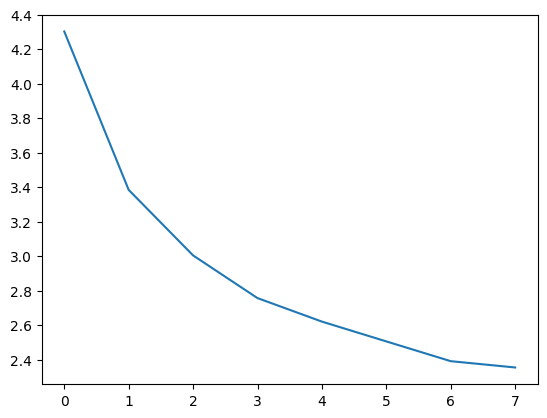

> nous ne pouvons pas encore le voir 
= we still can t see it 
< we can t see it  <EOS>

> je prefererais vraiment etre seul a l instant 
= i really would rather be alone right now 
< i would be alone so  <EOS>

> nous sommes toujours prudents 
= we re always careful 
< we always always know  <EOS>

> quand vas tu terminer ca 
= when are you going to finish this 
< when you are going on  <EOS>

> l anglais est dur n est ce pas 
= english is difficult isn t it 
< it s not easy in english  <EOS>

> pourquoi mentez vous 
= why do you lie 
< why are you why  <EOS>

> ca ressemble a un reve 
= it sounds like a dream 
< it s a long time  <EOS>

> il est necessaire que tu y ailles 
= it s necessary for you to go 
< there is no need for you  <EOS>

> l ingenieur grimpa le long du poteau telephonique 
= the engineer climbed the telephone pole 
< the police is going on the room  <EOS>

> ils sont courageux 
= they re brave 
< they re out of them  <EOS>

Input: je suis trop fatigué
Output: i m to

<ipython-input-13-bc2f61858e7e>:21: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([''] + input_sentence.split(' ') + ['<EOS>'], rotation=90)  # Input words on x-axis
<ipython-input-13-bc2f61858e7e>:22: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([''] + output_words)  # Output words on y-axis


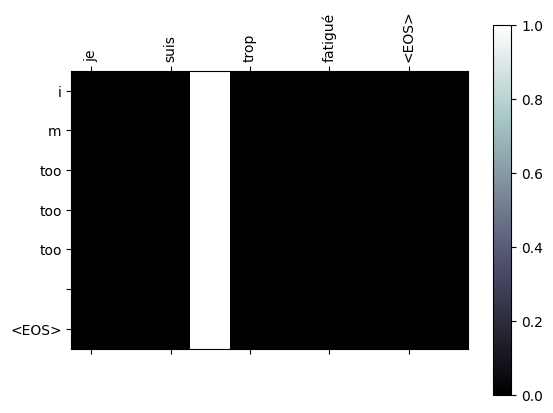

In [ ]:
# Load and prepare data
input_lang, output_lang, pairs = prepare_data('eng', 'fra', True)  # Load English-French sentence pairs, reversing the language order
print(f"Number of sentence pairs: {len(pairs)}")  # Print the total number of training pairs loaded
print("Vocabulary size:", input_lang.n_words, output_lang.n_words)  # Print vocabulary sizes for both input and output languages

# Initialize models
hidden_size = 256  # Set hidden layer size for the RNNs
encoder = EncoderRNN(input_lang.n_words, hidden_size).to(device)  # Initialize the encoder model with the input language's vocabulary size
attn_decoder = AttnDecoderRNN(hidden_size, output_lang.n_words, dropout_p=0.1).to(device)  # Initialize the attention-based decoder model

# Train models for 1000 iterations
train_iters(encoder, attn_decoder, n_iters=40000, pairs=pairs, input_lang=input_lang, output_lang=output_lang, print_every=5000)
# Train the encoder and decoder models on the data for 75000 iterations and print the loss every 5000 iterations

# Evaluate on random pairs and visualize attention
evaluate_randomly(encoder, attn_decoder, pairs, input_lang, output_lang)  # Evaluate and print translations of random pairs from the dataset
evaluate_and_show_attention("je suis trop fatigué", encoder, attn_decoder, input_lang, output_lang)  # Evaluate and visualize attention for a specific input sentence


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# Saving and Loading the Trained Model


In [ ]:
import os
import torch

encoder_path = os.path.join("myModels", "encoder.pth")
decoder_path = os.path.join("myModels", "decoder.pth")

# Function to save the model to Google Drive
def save_model(encoder, decoder, encoder_path=encoder_path, decoder_path=decoder_path):
    # Create the directory in Google Drive if it doesn't exist
    os.makedirs(os.path.dirname(encoder_path), exist_ok=True)

    # Save the models
    torch.save(encoder.state_dict(), encoder_path)
    torch.save(decoder.state_dict(), decoder_path)
    print("Models saved to myModels/")

# Function to load the model from Google Drive
def load_model(encoder, decoder, encoder_path=encoder_path, decoder_path=decoder_path):
    # Load the models
    encoder.load_state_dict(torch.load(encoder_path))
    decoder.load_state_dict(torch.load(decoder_path))
    print("Models loaded  from myModels/.")


## Save the model

In [ ]:
# Save the trained models to Google Drive
save_model(encoder, attn_decoder)



## Load the model

In [ ]:
# Later, load the models from Google Drive
load_model(encoder, attn_decoder)


## Loading the Model for Inference


In [ ]:
# Define model architecture
hidden_size = 256
encoder = EncoderRNN(input_lang.n_words, hidden_size).to(device)
attn_decoder = AttnDecoderRNN(hidden_size, output_lang.n_words, dropout_p=0.1).to(device)

# Load the saved weights into the model
encoder.load_state_dict(torch.load("encoder.pth"))
attn_decoder.load_state_dict(torch.load("decoder.pth"))


## Using the Loaded Model for New Input

In [20]:
# New input sentence to translate
new_sentence = "je suis très heureux"

# Evaluate and print the output
output_words, attentions = evaluate(encoder, attn_decoder, new_sentence, input_lang, output_lang)
output_sentence = ' '.join(output_words)
print("Translated sentence:", output_sentence)


Translated sentence: affects loyalty index coins receive receive receive genoa teetotaler equaling


# Evaluating Multiple Sentences At Once

In [21]:
def evaluate_batch(encoder, decoder, sentences, input_lang, output_lang, max_length=10):
    results = []
    for sentence in sentences:
        output_words, attentions = evaluate(encoder, decoder, sentence, input_lang, output_lang, max_length)
        output_sentence = ' '.join(output_words)
        results.append((sentence, output_sentence))
    return results

# Usage
sentences_to_translate = ["je suis trop fatigué", "il fait beau aujourd'hui", "j'aime programmer"]
translations = evaluate_batch(encoder, attn_decoder, sentences_to_translate, input_lang, output_lang)
for original, translated in translations:
    print(f"Input: {original} -> Output: {translated}")


Input: je suis trop fatigué -> Output: affects loyalty index comparing complications emoticons shintaro industrialization questionable lobby
Input: il fait beau aujourd'hui -> Output: worsened move says says says rapid shyly sorcerer alleviates gullible
Input: j'aime programmer -> Output: affects terrified isolated awkward sympathize lather quite simplest spreading voter


# Interactive Translation with User Input

In [23]:
def interactive_translation(encoder, decoder, input_lang, output_lang):
    while True:
        sentence = input("Enter a sentence in French (or type 'quit' to exit): ")
        if sentence.lower() == 'quit':
            break
        output_words, attentions = evaluate(encoder, decoder, sentence, input_lang, output_lang)
        print("Translation:", ' '.join(output_words))

# Usage
interactive_translation(encoder, attn_decoder, input_lang, output_lang)


Enter a sentence in French (or type 'quit' to exit): Bonsoir
Translation: affects loyalty index masterpiece sacrifice sacrificed frayed demented disconcerted proverbs
Enter a sentence in French (or type 'quit' to exit): Merci
Translation: affects loyalty index masterpiece sacrifice sacrificed frayed demented disconcerted proverbs
Enter a sentence in French (or type 'quit' to exit): quit


# Detailed Attention Visualization

an attention heatmap for a sequence-to-sequence model, specifically for the French input sentence "je suis trop fatigué"

<ipython-input-24-cc5396167dd4>:7: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([''] + input_sentence.split(' ') + ['<EOS>'], rotation=90, fontsize=12)
<ipython-input-24-cc5396167dd4>:8: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([''] + output_words, fontsize=12)


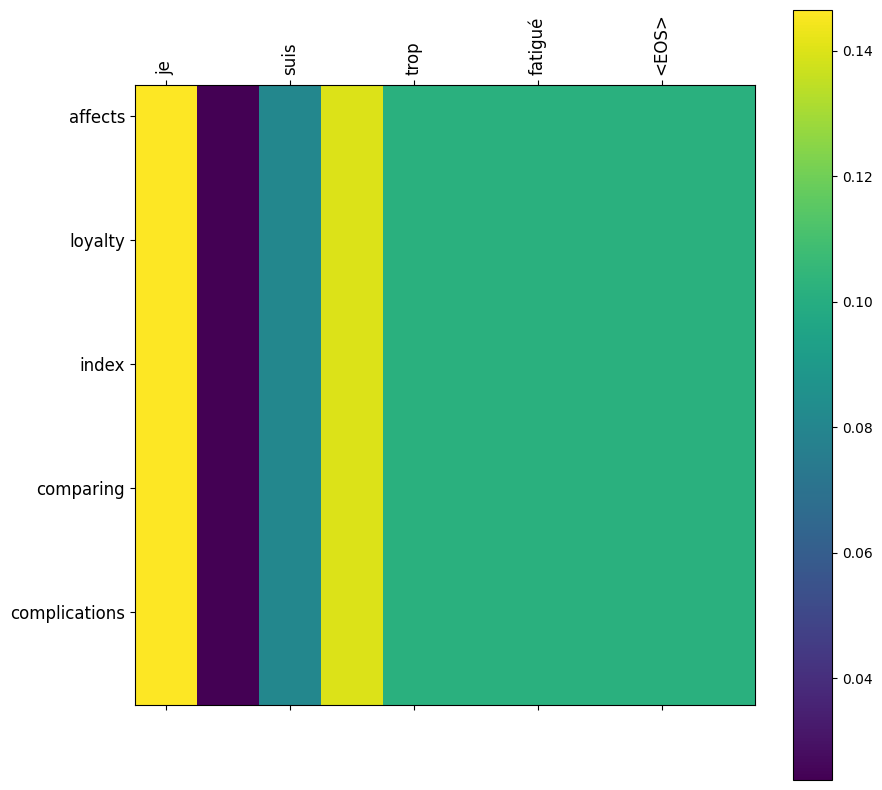

In [24]:
def show_detailed_attention(input_sentence, output_words, attentions):
    fig, ax = plt.subplots(figsize=(10, 10))  # Adjust figure size
    cax = ax.matshow(attentions.numpy(), cmap='viridis')  # Choose a different color map for clarity
    fig.colorbar(cax)

    # Set up axis labels with input and output words
    ax.set_xticklabels([''] + input_sentence.split(' ') + ['<EOS>'], rotation=90, fontsize=12)
    ax.set_yticklabels([''] + output_words, fontsize=12)

    plt.show()

# Usage
output_words, attentions = evaluate(encoder, attn_decoder, "je suis trop fatigué", input_lang, output_lang)
show_detailed_attention("je suis trop fatigué", output_words, attentions)


The image you provided shows an attention heatmap for a sequence-to-sequence model, specifically for the French input sentence "je suis trop fatigué". The heatmap is likely illustrating the alignment of each word in the input sentence with each word in the output (target) sentence. The rows correspond to the output words, and the columns represent the input words. The color intensity indicates the attention weight, with brighter colors signifying higher attention values.

However, from the provided heatmap:
- The output words (on the y-axis) do not seem to align correctly with the intended target sentence. Instead, they appear to be random words like "affects", "loyalty", "index", etc., which suggests that either:
  - The target vocabulary or indices might have been incorrectly mapped during evaluation, or
  - There might be an issue with loading or defining the output vocabulary.

### Suggestions to Address This Issue:
1. **Check Target Vocabulary Mapping**:
   - Verify that the output vocabulary (`output_lang.index2word`) is correctly initialized and loaded.
   - Ensure that the indices used during the evaluation are accurately mapping to the words in the target language (e.g., English in this case).

2. **Review the Attention Mechanism**:
   - Confirm that the `evaluate` function and the `show_attention` function are correctly pulling the attention weights from the model’s decoder. Sometimes, inconsistencies in tensor shapes can lead to incorrect attention heatmaps.

3. **Re-evaluate and Print Output Sentence**:
   - After running the `evaluate_and_show_attention` function, print the generated output sentence in plain text and confirm that it matches the expected output. This can help identify if there’s a mismatch in vocabulary.

4. **Plot Attention with Correct Labels**:
   - Ensure that when setting `ax.set_yticklabels` in the `show_attention` function, you are using the correctly mapped output words.


# Saving Attention Visualizations

<ipython-input-25-c26928e08e71>:6: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([''] + input_sentence.split(' ') + ['<EOS>'], rotation=90, fontsize=12)
<ipython-input-25-c26928e08e71>:7: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([''] + output_words, fontsize=12)


Attention plot saved as savedPlots/attention_fatigue.png


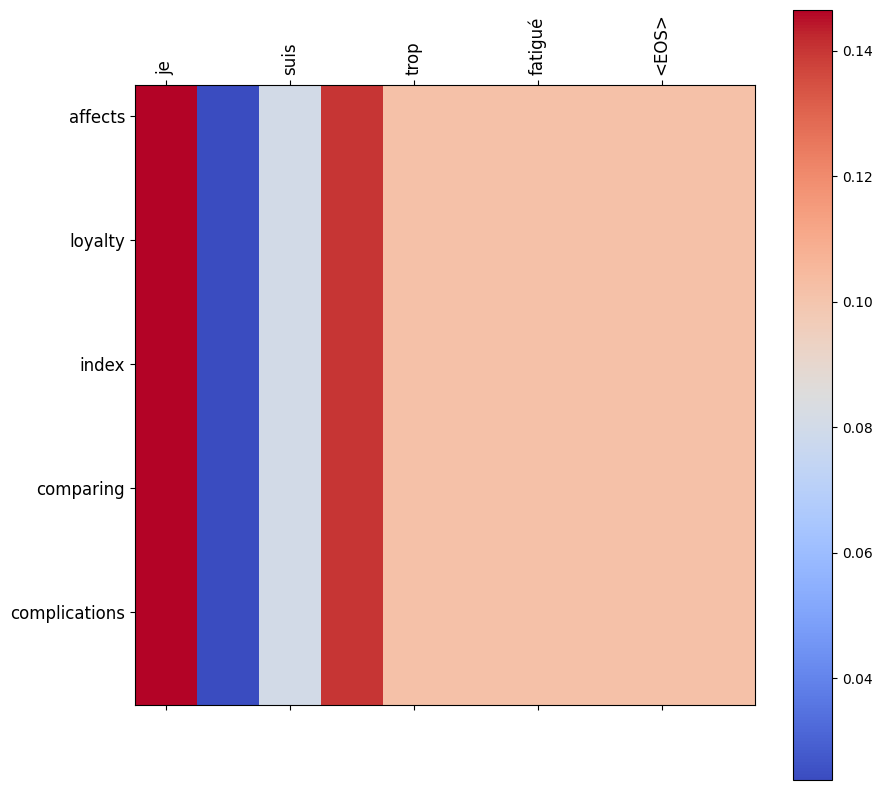

In [25]:
def save_attention_plot(input_sentence, output_words, attentions, file_name="attention_plot.png"):
    fig, ax = plt.subplots(figsize=(10, 10))
    cax = ax.matshow(attentions.numpy(), cmap='coolwarm')
    fig.colorbar(cax)

    ax.set_xticklabels([''] + input_sentence.split(' ') + ['<EOS>'], rotation=90, fontsize=12)
    ax.set_yticklabels([''] + output_words, fontsize=12)

    # Create 'savedPlots' folder if it doesn't exist
    os.makedirs("savedPlots", exist_ok=True)

    # Corrected and improved path for saving
    save_path = os.path.join("savedPlots", file_name)
    plt.savefig(save_path)
    print(f"Attention plot saved as {save_path}")

# Usage
output_words, attentions = evaluate(encoder, attn_decoder, "je suis trop fatigué", input_lang, output_lang)
save_attention_plot("je suis trop fatigué", output_words, attentions, file_name="attention_fatigue.png")


# Calculate BLEU Score for Translation Quality

In [29]:
def calculate_bleu(encoder, decoder, pairs, input_lang, output_lang):
    scores = []
    smoothing_function = SmoothingFunction().method3  # Adjusted smoothing function

    print("Starting BLEU score calculation with smoothing method3...")

    for i, pair in enumerate(pairs[:100]):  # Limiting pairs to 100 for quicker testing
        print(f"\nEvaluating sentence pair {i + 1}/{len(pairs)}")
        print("Input Sentence:", pair[0])
        print("Reference Translation:", pair[1])

        output_words, _ = evaluate(encoder, decoder, pair[0], input_lang, output_lang)
        candidate = output_words[:-1]  # Exclude <EOS>
        reference = pair[1].split()

        print("Model's Predicted Translation:", " ".join(candidate))

        score = sentence_bleu([reference], candidate, smoothing_function=smoothing_function)
        scores.append(score)
        print(f"BLEU score for this sentence: {score:.4f}")

    avg_bleu_score = sum(scores) / len(scores)
    print(f"\nAverage BLEU score for the dataset: {avg_bleu_score:.4f}")
    return avg_bleu_score

# Usage
calculate_bleu(encoder, attn_decoder, pairs, input_lang, output_lang)


Starting BLEU score calculation with smoothing method3...

Evaluating sentence pair 1/135842
Input Sentence: dans les sondages les deux partis sont a egalite 
Reference Translation: in the polls both parties are on par 
Model's Predicted Translation: discarded victorian hawk saw beside anything dedication gotten sacrificed
BLEU score for this sentence: 0.0000

Evaluating sentence pair 2/135842
Input Sentence: j ai hate d avoir de tes nouvelles 
Reference Translation: i am looking forward to hearing from you soon 
Model's Predicted Translation: discarded secondhand mortal doctor distance backward partly pull respect
BLEU score for this sentence: 0.0000

Evaluating sentence pair 3/135842
Input Sentence: l ouvrage se trouve sur la table 
Reference Translation: the book is on the table 
Model's Predicted Translation: discarded super fool silhouette offensive spacious ludicrous holdings cat
BLEU score for this sentence: 0.0000

Evaluating sentence pair 4/135842
Input Sentence: il est tres d

0.0

The low BLEU scores and nonsensical translations indicate that there may be an issue with the model training, data preprocessing, or vocabulary alignment between the input and target languages. Here are some detailed areas to investigate to improve the performance:

#### 1. **Check Training Data Quality**
   - **Sentence Pair Alignment**: Verify that the pairs in your training data are properly aligned between source and target languages.
   - **Vocabulary Coverage**: If many words in the evaluation sentences are not part of the vocabulary learned during training, the model may output random words that don’t make sense in context.
   - **Training Data Size**: Ensure you have a sufficient amount of quality data. Small training data or limited vocabulary can lead to poor generalization.

#### 2. **Model Training Duration**
   - **Training Iterations**: The model might not be trained for enough iterations. Try increasing `n_iters` (e.g., from 75,000 to 100,000 or more) to allow the model to learn better representations.
   - **Loss Monitoring**: Check the loss over time during training to ensure it’s decreasing steadily. If it’s not, it may indicate issues with the data or model parameters.

#### 3. **Hyperparameter Tuning**
   - **Hidden Size**: A larger hidden size can help capture more complex patterns in language pairs, but it also increases the model complexity.
   - **Learning Rate**: Experiment with different learning rates. Sometimes, reducing the learning rate can lead to better convergence, especially after the initial training period.

#### 4. **Preprocessing Adjustments**
   - **Tokenization and Normalization**: Ensure that the `normalize_string` function effectively removes special characters and unnecessary whitespace. Adding a tokenizer that handles punctuation and lowercasing might also help.
   - **Maximum Sequence Length**: If the maximum length (`max_length`) is too small, the model might be truncating important parts of longer sentences. Increasing `max_length` could improve translation quality for longer sentences.
   
#### 5. **Evaluate with Smoothing Techniques**
   - Since BLEU score penalizes lack of n-gram matches, especially in small datasets or highly varied sentences, consider trying different smoothing functions in the BLEU calculation. For instance:
     ```python
     smoothing_function = SmoothingFunction().method3
     ```

#### 6. **Check for Overfitting**
   - If the model performs well on training data but fails on evaluation, it could indicate overfitting. In that case, apply regularization techniques, such as dropout or weight decay, to improve generalization.

#### 7. **Visualize Attention Weights**
   - Sometimes, the attention weights can reveal patterns in the model's focus. By visualizing attention maps, you can diagnose if the model is focusing on incorrect parts of the input sequence.

#### 8. **Inspect Model Outputs During Training**
   - Evaluate a few sentences at intervals during training to see if there’s any gradual improvement. This can reveal if the model is learning meaningful translations or just outputting random words throughout.

#### Next Steps
1. **Retrain with a Larger Dataset**: If available, use more sentence pairs for training.
2. **Inspect Output after Training**: Periodically check translations during training to detect issues early.
3. **Hyperparameter Exploration**: Experiment with different hyperparameters, especially `hidden_size` and `learning_rate`.
4. **Adjust BLEU Calculation Scope**: Test on a smaller subset of pairs first to validate improvements before evaluating on the full dataset.

By addressing these areas, you should see improvements in translation quality and BLEU scores.